In [1]:
ticker = "JPM"
freq = "1D"
target_col = "Adj Close",
start_date = "2000-01-01"
end_date = "2024-11-30"

predit_points = 30

In [2]:
import yfinance as yf

data = yf.download(ticker, start=start_date, end=end_date)[target_col][ticker]
# train_size = int(len(data) * train_ratio)

train_data = data[:-predit_points]
test_data = data[-predit_points:]

[*********************100%***********************]  1 of 1 completed


In [3]:
from pmdarima.arima import auto_arima

model = auto_arima(train_data, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=2.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=24698.551, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=22426.485, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=21767.234, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=21489.545, Time=0.26 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=21115.305, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=21004.000, Time=0.43 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=2.61 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=2.87 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=21005.997, Time=1.22 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 10.874 seconds


In [4]:
from tqdm import tqdm
from pmdarima.arima import ARIMA

import warnings
warnings.filterwarnings('ignore')

def forecast_arima_model(order, steps):
    forecasts = []
    lower_bound = []
    upper_bound = []
    for i in tqdm(range(steps)):
        fitted_model = ARIMA(order=order).fit(data[:len(train_data)+i])
        forecast, ci = fitted_model.predict(n_periods=1, return_conf_int=True, alpha=0.1)
        forecasts.append(forecast.values[0])
        lower_bound.append(ci[0][0])
        upper_bound.append(ci[0][1])
    return forecasts, lower_bound, upper_bound

order = (5,2,0)
pred, l_bound, u_bound = forecast_arima_model(order=order, steps=len(test_data))


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


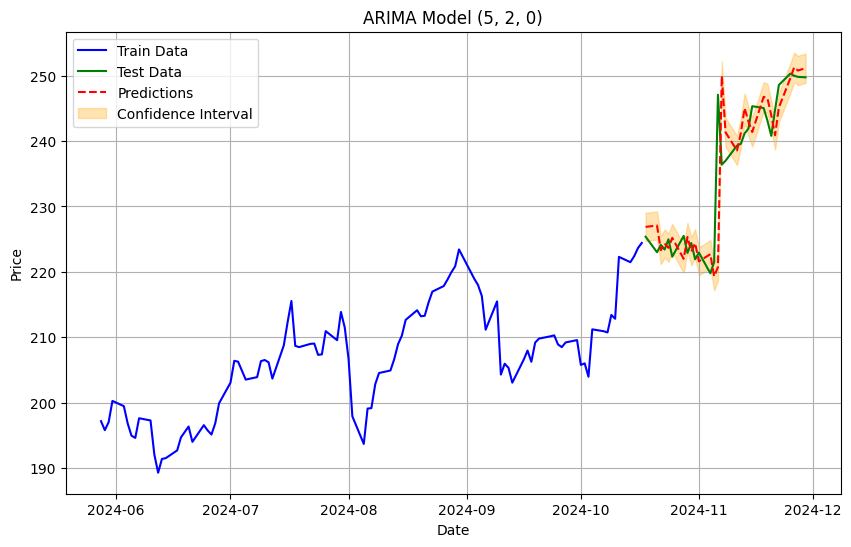

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(train_data.index[-100:], train_data[-100:], label='Train Data', color='blue')
plt.plot(test_data.index, test_data, label='Test Data', color='green')
plt.plot(test_data.index, pred, label='Predictions', color='red', linestyle='--')
plt.fill_between(test_data.index, l_bound, u_bound, alpha=0.3, color='orange', label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'ARIMA Model {order}')
plt.legend()
plt.grid(True)
plt.savefig(f'images/{ticker}_ARIMA.png')
plt.show()

In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

actual = np.array(test_data.values)
predicted = np.array(pred)

mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predicted)

print(ticker)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

JPM
Mean Absolute Error (MAE): 3.43
Mean Squared Error (MSE): 35.27
Root Mean Squared Error (RMSE): 5.94
R² Score: 0.70
